dependencies:


> CUDA (cuda is preinstalled, but MUST set CoLab env. to run on GPU)


> miniconda (used to install dependencies that pip cannot install)


> rdkit (installed with miniconda)


> ReLeaSE library (contains pretrained G and P models)


> testingdata.smi (shortened data packet used for loading in the generator)


> OpenChem (need this git library - not sure what the use is?)












In [ ]:
# Install Miniconda, then using it, install RDKit. Takes 2-3 minutes - found through YT
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-06-17 23:12:46--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-06-17 23:12:46--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  84.75M   190MB/s    in 0.4s    

2020-06-17 23:12:47 (190 MB/s) - ‘Miniconda3-latest-Linux

In [ ]:
!python --version

Python 3.6.9


In [ ]:
# set up env so that we can import rd kit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# actually clone over ReLeaSE
!git clone https://github.com/isayev/ReLeaSE.git
%cd ReLeaSE

Cloning into 'ReLeaSE'...
remote: Enumerating objects: 545, done.
remote: Total 545 (delta 0), reused 0 (delta 0), pack-reused 545
Receiving objects: 100% (545/545), 449.75 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Checking out files: 100% (29/29), done.
/content/ReLeaSE


In [ ]:
# sanity check to see if CUDA is availabe
import torch
torch.cuda.is_available()


True

In [ ]:
# only need to mount drive if we move training data to drive instead of manual import each run

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# instantiates the generator
%env CUDA_VISIBLE_DEVICES=1

%load_ext autoreload
%autoreload 2

# changes working directory to be inside the ReLeaSE clone
import sys
sys.path.append('./release/')

# imports requesite libraries 
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# we reset the gen_data_path to point to a shortened set of data to prevent running out of RAM

# Smaller data set, for now used because we don't have supercomputer  
gen_data_path = './data/testingdata.smi'

#Characters that the generator is limited to when generating chemical data, doesn't want to create invalid strings(SMILE ALPHABET)
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

""" 
Instantiate an instance of the GeneratorData object, which is  responsible for generating SMILE data
based on given tokens from above, training data from the smi file, 
??? Is this used to produce training data for the generator ??? 
"""
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

# Plots molecules that meet specification for hydrophobisity out of all molecules set ot be generated and outputs/plots percent valid molecules and molecules with desired traits
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()


def estimate_and_update(generator, predictor, n_to_generate):
    print(type(n_to_generate))
    generated = []
    pbar = tqdm(range(n_to_generate))
    print(type(pbar))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    #NExt few lines filters out duplicate and invalid smiles    
    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction


# use 2 agents: env and control - query the env to determine the params to use in this generator NN,
# need to explore the space (hyper param tuning)

# anotate

# parameters that define the generator's NN, as well as its training
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001

#Gradient descent optimizer algorithm, seeks to decrease the learning rate to try and avoid missing minima, also robust to noisy gradient information, different model architectures and hyperparameters.
optimizer_instance = torch.optim.Adadelta

"""
Code that creates an isntance of the StackAugmented RNN , sets hidden layer size, output and input numbers,
as type of RNN(architecture), since there is only 1 hidden layer, bidirectionality does not apply here.
"""
my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

"""
Stack Augmented RNN is different from traditional GRU's by having more gates than 
the normal GRU's. These gates are used to hold on to long term counting information, that 
would not normally be passed in a traditional GRU. In the comparison between the non Stack and
Stack RNN they found that the non Stack produced fewer valid results, less internal diversity, less diversity compared
to the training set,
"""

# load in the generator instead of actually training
# losses = my_generator.fit(gen_data, 1500000)
# plt.plot(losses)
# my_generator.evaluate(gen_data)
# my_generator.save_model(model_path)

#Since we are just loading a pretrained model, this is just the path to it
model_path = './checkpoints/generator/checkpoint_biggest_rnn'


#Wrapper for pytorch functionality
my_generator.load_model(model_path)

print("finished loading generator")

env: CUDA_VISIBLE_DEVICES=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


finished loading generator


In [ ]:
# set up the predictor - need OpenChem library
!git clone --single-branch --branch develop https://github.com/Mariewelt/OpenChem.git
sys.path.append('./OpenChem/')
sys.path.append('./release')

from rnn_predictor import RNNPredictor

#in order to get tensorflow to work, space was added
predictor_tokens = tokens + [' ']
#predictor_tokens = tokens
path_to_params = './checkpoints/logP/model_parameters.pkl'
path_to_checkpoint = './checkpoints/logP/fold_'

# just create a RNNPredictor instance , load hidden layers and checkpoints, because we dont train it here
my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, predictor_tokens)

fatal: destination path 'OpenChem' already exists and is not an empty directory.


Generating molecules...:   0%|          | 0/1000 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Calculating predictions...: 100%|██████████| 773/773 [00:00<00:00, 968.69it/s] 
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()


Percentage of predictions within drug-like region: 0.8939197930142303
Proportion of valid SMILES: 0.773


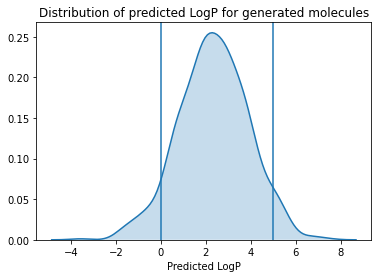

In [ ]:
# should give us a logP graph output of our results 
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=1000)

In [ ]:
# sometimes need to opt. mult. properties of a drug/chem compound (pareto)
# req. design of a reward func. that biases the numerical scores of each prop.

# intra cluster dist must be less than intercluster dist
# cluster the chem compounds into similar molecules, then use dist func to separate clusters
# must look at pairwise dist of molecules, optimizing *maybe the sum of dists.

# bias the logP graph w/ RL
from reinforcement import Reinforcement


#Same RNN as earlier but now we are goint to bias it using RL
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

# Setting up some parameters for the experiment
n_to_generate = 200 // 10
n_policy_replay = 10
n_policy = 15
n_iterations = 60 // 5

#just calculates simple moving average 
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma


def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    #Valid smiles, total smiles and invalid smiles retured by predict function, assign reward based on that
    mol, prop, nan_smiles = predictor.predict([smiles])
    #Predictor is function acting on smile string to determine value used in determining reward
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0):
        return 11.0
    else:
        return 1.0

print("done with reinforcement setup")

done with reinforcement setup


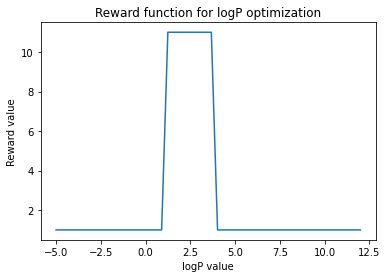

In [ ]:
# plots the RL reward func.
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('logP value')
plt.ylabel('Reward value')
plt.title('Reward function for logP optimization')
plt.show()

In [ ]:
# does the actual reinforcement
#Creates a Reinforcement object, uses previous generator and predictor except each smile is now put through the reward function
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

#Only generator is affected by his since we use the same predictor

rewards = []
rl_losses = []

print(n_iterations)
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

12


./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
./OpenChem/openchem/modules/encoders/rnn_encoder.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).cuda()
Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]


KeyboardInterrupt: ignored